In [1]:
# ## Introduction
# In this project, we aim to predict whether a player will subscribe to the newsletter based on their in-game behavior and characteristics using R, ggplot2, and tidymodels.

In [2]:
# ## Load libraries
library(tidyverse)
library(tidymodels)
library(lubridate)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# ## Data Loading
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# ## Data Cleaning
players <- players |>
  mutate(Age = if_else(is.na(Age), median(Age, na.rm = TRUE), Age))

sessions_clean <- sessions |>
  filter(!is.na(end_time) & !is.na(original_end_time)) |>
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_duration = as.numeric(difftime(end_time, start_time, units = "mins")))


In [5]:
# ## Data Wrangling
session_summary <- sessions_clean |>
  group_by(hashedEmail) |>
  summarize(total_sessions = n(),
            average_session_duration = mean(session_duration, na.rm = TRUE))
players_merged <- players |>
  left_join(session_summary, by = "hashedEmail") |>
  mutate(total_sessions = replace_na(total_sessions, 0),
         average_session_duration = replace_na(average_session_duration, 0))

In [6]:
players_merged <- players |>
  left_join(session_summary, by = "hashedEmail") |>
  mutate(total_sessions = replace_na(total_sessions, 0),
         average_session_duration = replace_na(average_session_duration, 0))

In [7]:
# ## Exploratory Data Analysis (EDA)

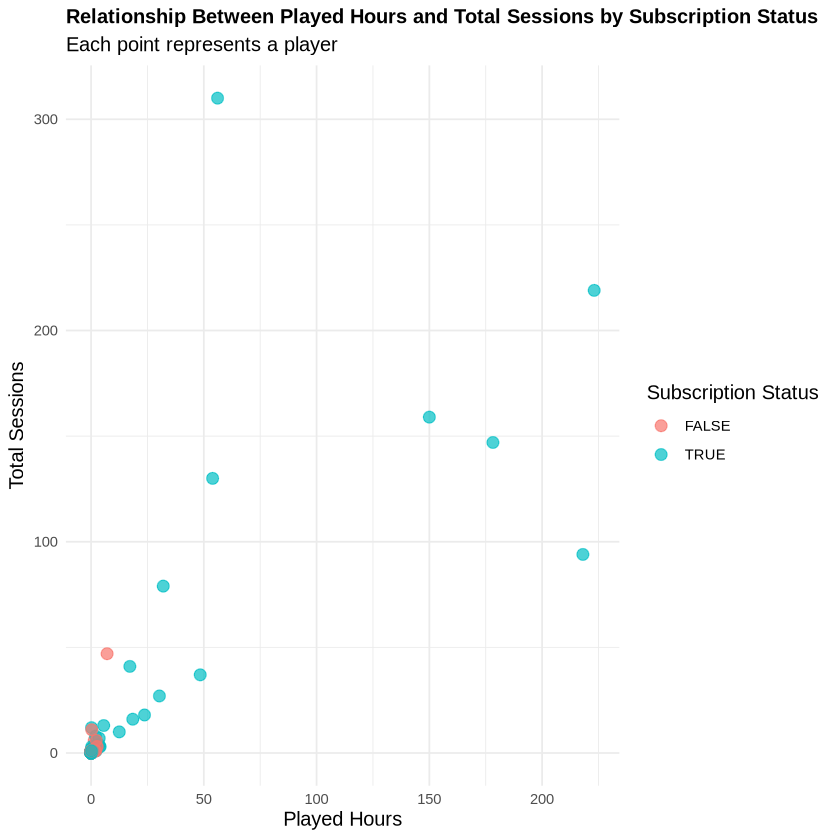

In [8]:
# Scatter plot: Played Hours vs. Total Sessions by Subscription
ggplot(players_merged, aes(x = played_hours, y = total_sessions, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  labs(title = "Relationship Between Played Hours and Total Sessions by Subscription Status",
       subtitle = "Each point represents a player",
       x = "Played Hours",
       y = "Total Sessions",
       color = "Subscription Status") +
  theme_minimal() +
  theme(plot.title = element_text(size = 12, face = "bold"),
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.title = element_text(size = 12))

In [9]:
# ## Model Building with tidymodels (K-Nearest Neighbors Classification)
set.seed(123)

In [10]:
# Prepare the data
players_merged <- players_merged |>
  mutate(subscribe = as_factor(subscribe))

In [11]:
# Create initial split
data_split <- initial_split(players_merged, prop = 0.7, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

In [17]:
# Create recipe
player_recipe <- recipe(subscribe ~ experience + gender + played_hours + Age + total_sessions + average_session_duration, data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_normalize(all_numeric_predictors())
player_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Dummy variables from: all_nominal_predictors()

• Centering and scaling for: all_numeric_predictors()



In [18]:
# K-Nearest Neighbors Model
knn_spec <- nearest_neighbor(neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(player_recipe)

knn_fit <- knn_workflow |>
  fit(data = train_data)

knn_spec
knn_workflow
knn_fit


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_dummy()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_dummy()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5))

Type of response variable: nominal
Minimal misclassification: 0.3161765
Best kernel: optimal
Best k: 5

In [20]:
# Predictions and Evaluation
knn_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data |>
              select(subscribe))

knn_predictions

.pred_class,subscribe
<fct>,<fct>
TRUE,TRUE
TRUE,TRUE
TRUE,FALSE
TRUE,TRUE
TRUE,FALSE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE
TRUE,TRUE


In [22]:
# Metrics and Confusion Matrix
knn_metrics <- knn_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

knn_conf_mat <- knn_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

knn_metrics
knn_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.66666667
kap,binary,-0.01351351


          Truth
Prediction FALSE TRUE
     FALSE     2    6
     TRUE     14   38